In [1]:
# Importando Bibliotecas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
import math
import scipy.stats as stats
from tqdm import tqdm 
import time
import multiprocessing as mp
from scipy.stats import norm
from scipy.stats import poisson
from scipy.optimize import curve_fit
#import latexify
import random
import scipy.special as sp
from scipy import signal
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import butter, freqz, filtfilt
import datetime
import yfinance as yf
import mplcyberpunk
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email import encoders
import time
from selenium import webdriver
from selenium.webdriver.firefox.service import Service as FirefoxService
from webdriver_manager.firefox import GeckoDriverManager
import datetime
import pandas_datareader.data as pdr
from numpy import linalg as LA
import yfinance as yf
yf.pdr_override()

# Projeto
### Análise de Fundos Imobiliários (fins de aprendizado) 
 - 1: Análise superficial do IFIX em relação ao IBOVESPA.
 - 2: Webscrapping do statusinvest para analisar todos os fundos imobiliarios disponiveis.
 - 3: Simular uma carteira de investimento teórica (Monte Carlo) apenas com fundos imobiliarios
 - 4: Enviar e-mail automático com as informações mais importantes e um breve resumo da análise.

Vamos supor que a composição histórica do IFIX obedeça apenas as listadas em abril de 2021 e abril de 2023, para fins de conveniencia (foram os dados que consegui acesso mais fácil).

**1)**

In [2]:
## Dando erro no download
codigos = ["^BVSP","IFIX.SA"] #Ibovespa e IFIX
data_final = pd.Timestamp.today()
data_inicial = data_final - pd.DateOffset(months=9)
dados_mercado = yf.download(codigos, data_inicial, data_final, ignore_tz=True)['Adj Close']

[*********************100%***********************]  2 of 2 completed


In [3]:
codigos = ["^BVSP","IFIX.SA"] #Ibovespa e IFIX
hoje = datetime.datetime.now()
data_inicial = hoje - datetime.timedelta(days=220) #pegando dados desde metade de 2022 até hoje (fev 2023)
dados_mercado = pdr.get_data_yahoo(codigos, data_inicial, hoje)['Adj Close']

[*********************100%***********************]  2 of 2 completed


In [4]:
dados_mercado

,IFIX.SA,^BVSP
Date,,
2022-08-30,NaN,110431.0
2022-08-31,NaN,109523.0
2022-09-01,NaN,110405.0
2022-09-02,NaN,110864.0
2022-09-05,NaN,112203.0
...,...,...
2023-03-31,NaN,101882.0
2023-04-03,NaN,101506.0
2023-04-04,NaN,101869.0


Ao que parece, há um erro especificamente no yahoo finance quando se trata de levantar dados do IFIX. 

### Tentar outra API
 - Alpha Vantage

In [5]:
ALPHA_VANTAGE_KEY = "E5Q5PIRX35FQE5R5" #Codigo adquirido ao me registrar

In [6]:
from alpha_vantage.timeseries import TimeSeries
ts = TimeSeries(key=ALPHA_VANTAGE_KEY,output_format='pandas')

In [7]:
ts.get_symbol_search('IFIX') #Descobrindo o sufixo utilizado nessa API

(           1. symbol              2. name 3. type         4. region  \
 date                                                                  
 1970-01-01  IFIX.SAO  INDICE DE FII INDEX  Equity  Brazil/Sao Paolo   
 
            5. marketOpen 6. marketClose 7. timezone 8. currency 9. matchScore  
 date                                                                           
 1970-01-01         10:00          17:30      UTC-03         BRL        0.7273  ,
 None)

In [8]:
#ts.get_daily("IFIX.SAO") ## Somente Premium
ts.get_daily_adjusted("IFIX.SAO") #Versão gratuita

(              1. open    2. high     3. low   4. close  5. adjusted close  \
 date                                                                        
 2023-04-06  2760.2900  2765.3501  2757.5100  2760.3799          2760.3799   
 2023-04-05  2761.0000  2767.9700  2759.2600  2760.2600          2760.2600   
 2023-04-04  2753.1001  2764.3501  2753.1001  2761.0000          2761.0000   
 2023-04-03  2760.9399  2772.5801  2751.4199  2753.1101          2753.1101   
 2023-03-31  2760.9600  2760.9600  2760.9600  2760.9600          2760.9600   
 ...               ...        ...        ...        ...                ...   
 2022-11-21  2878.3101  2887.4800  2867.3999  2867.8501          2867.8501   
 2022-11-18  2878.2800  2878.2800  2878.2800  2878.2800          2878.2800   
 2022-11-17  2914.3999  2916.0200  2859.6101  2864.0100          2864.0100   
 2022-11-16  2931.1899  2940.8601  2911.6499  2914.3999          2914.3999   
 2022-11-14  2931.1899  2931.1899  2931.1899  2931.1899         

In [9]:
dados_ifix, meta = ts.get_daily_adjusted("IFIX.SAO",outputsize='full') #separando os dados que preciso
dados_ifix

,1. open,2. high,3. low,4. close,5. adjusted close,6. volume,7. dividend amount,8. split coefficient
date,,,,,,,,
2023-04-06,2760.2900,2765.3501,2757.5100,2760.3799,2760.3799,0.0,0.0,1.0
2023-04-05,2761.0000,2767.9700,2759.2600,2760.2600,2760.2600,0.0,0.0,1.0
2023-04-04,2753.1001,2764.3501,2753.1001,2761.0000,2761.0000,0.0,0.0,1.0
2023-04-03,2760.9399,2772.5801,2751.4199,2753.1101,2753.1101,0.0,0.0,1.0
2023-03-31,2760.9600,2760.9600,2760.9600,2760.9600,2760.9600,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...
2013-01-15,1584.9600,1587.1300,1581.5900,1583.7600,1583.7600,0.0,0.0,1.0
2013-01-14,1587.2200,1588.4600,1582.7000,1584.4500,1584.4500,0.0,0.0,1.0
2013-01-11,1589.8700,1590.0300,1583.6600,1587.2100,1587.2100,0.0,0.0,1.0


<AxesSubplot: xlabel='date'>

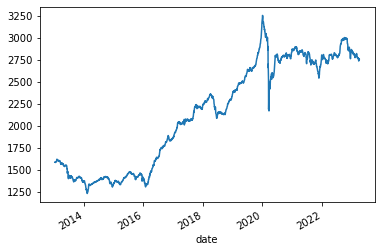

In [10]:
dados_ifix['5. adjusted close'].plot()

In [11]:
ifix_anual = dados_ifix['5. adjusted close'].resample("Y").last() #pegando dados anuais do IFIX
media_anual = dados_ifix['5. adjusted close'].resample("Y").mean()
#calcular fechamento do dia, retorno no ano dos ativos
retorno_anual_ifix = ifix_anual.pct_change() #funcao que automatiza isso
retorno_anual_ifix = retorno_anual_ifix.dropna()
retorno_anual_ifix

date
2014-12-31   -0.027628
2015-12-31    0.054086
2016-12-31    0.323346
2017-12-31    0.194055
2018-12-31    0.056203
2019-12-31    0.359752
2020-12-31   -0.102399
2021-12-31   -0.022772
2022-12-31    0.022226
2023-12-31   -0.037232
Freq: A-DEC, Name: 5. adjusted close, dtype: float64

In [12]:
ifix_mensal = dados_ifix['5. adjusted close'].resample("M").last() # Pegando dados mensais do IFIX
retorno_mensal_ifix = ifix_mensal.pct_change().dropna()
retorno_mensal_ifix

date
2013-02-28   -0.009840
2013-03-31   -0.011615
2013-04-30   -0.019198
2013-05-31    0.000232
2013-06-30   -0.072030
                ...   
2022-12-31   -0.000028
2023-01-31   -0.016040
2023-02-28   -0.004519
2023-03-31   -0.016889
2023-04-30   -0.000210
Freq: M, Name: 5. adjusted close, Length: 123, dtype: float64

In [13]:
ibov = dados_mercado['^BVSP'].sort_index(ascending = False) #sort_values(by=['PATRIMONIO'], ascending=False) #ascending=False para organizar de ordem decrescente
ifix =  dados_ifix['5. adjusted close'][:150]

In [14]:
ibov_anual = ibov.resample("Y").last() #pegando dados anuais do IBOVESPA
media_anual = ibov.resample("Y").mean()
#calcular fechamento do dia, retorno no ano dos ativos
retorno_anual_ibov = ibov_anual.pct_change()
retorno_anual_ibov = retorno_anual_ibov.dropna()
retorno_anual_ibov

Date
2023-12-31   -0.083695
Freq: A-DEC, Name: ^BVSP, dtype: float64

In [15]:
ibov_mensal = ibov.resample("M").last() #pegando dados anuais do IBOVESPA
media_mensal = ibov.resample("M").mean()
#calcular fechamento do dia, retorno no ano dos ativos
retorno_mensal_ibov = ibov_mensal.pct_change()
retorno_mensal_ibov = retorno_mensal_ibov.dropna()
retorno_mensal_ibov

Date
2022-09-30    0.004693
2022-10-31    0.054527
2022-11-30   -0.030602
2022-12-31   -0.021825
2023-01-31    0.031818
2023-02-28   -0.075750
2023-03-31   -0.029066
2023-04-30   -0.010404
Freq: M, Name: ^BVSP, dtype: float64

In [16]:
#Colocando tudo em Data Frame para podermos manipular com mais facilidade
df_ibov = pd.DataFrame(data=ibov)
df_ifix = pd.DataFrame(data=ifix)
df_ifix.rename(columns = {'5. adjusted close':'IFIX.SA'}, inplace=True)

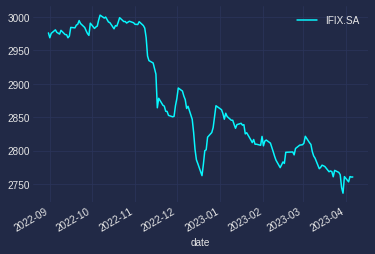

In [17]:
plt.style.use('cyberpunk')

df_ifix.plot()

#salvar a imagem
plt.savefig('IFIX.png', dpi = 300)

plt.show()

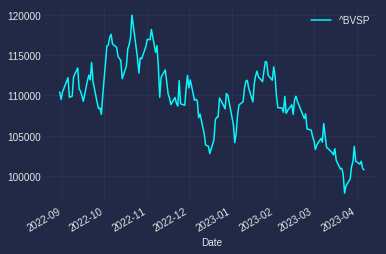

In [18]:
plt.style.use('cyberpunk')
df_ibov.plot()
plt.show()

In [19]:
df_ifix.describe()

,IFIX.SA
count,150.000000
mean,2872.141932
std,85.912308
min,2736.120100
25%,2801.322450
50%,2848.709950
75%,2976.050000
max,3002.830100


In [20]:
df_ibov.describe()

,^BVSP
count,151.000000
mean,109307.079470
std,4622.290097
min,97926.000000
25%,106458.000000
50%,109698.000000
75%,112302.000000
max,119929.000000


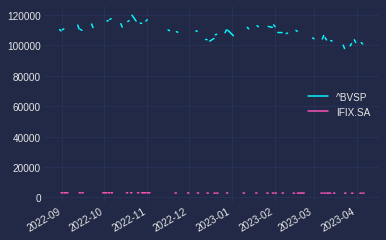

In [21]:
#plt.title('Comparação entre a evolução do IBOVESPA e IFIX')
pd.concat([df_ibov, df_ifix], ignore_index = False).plot() #Não possuem exatamente mesmas datas
plt.show()

A diferença absal entre as pontuações do IBOVESPA e IFIX tornam a análise de ambas (simultaneamente) um tanto inutil. Ainda assim, é interessante perceber que o IBOVESPA de fato possui não só muito mais pontuação, mas também muito mais volatilidade, tornando o investimento em fundos imobiliários mais conservador.

In [22]:
#Composição 'histórica' do IFIX com base em sua composição em abril de 2021 e abril de 2023
comp_ifix = pd.read_excel("comp_ifix.xlsx")
fundos_listados = []
for i in comp_ifix.values.tolist():
    fundos_listados.extend(i)

Até agora já buscamos as informações sobre o IBOVESPA e a composição parcial da carteira IFIX. Acabamos de obter a lista com todos os IFIX que irei considerar como parte histórico de sua composição (consideração ERRADA, pois ignora todo o ano de 2022 e segunda metade de 2021, sendo considerada apenas por fins didáticos). Agora criarei um bot que irá buscar, automaticamente todos os fundos imobiliários no site *statusinvest*. Isso significa que nossa análise terá dados sempre atualizados, enquanto o codigo funcionar.
Irei adicionar ao histórico IFIX os fundos diferentes que formos ler no website (de forma que o codigo atualize a lista acima) para que, posteriormente, possamos montar uma pequena carteira de investimento ou possamos prever a pequena volatilidade da nossa carteira com Simulações Monte Carlo. Por fim, planejo mandar-me um e-mail automatico com as informações mais importantes.

**2)**

In [23]:
driver = webdriver.Firefox( service=FirefoxService(GeckoDriverManager().install())
)#nosso bot que irá abrir o navegador e procurar os sites

[WDM] - Downloading: 19.2kB [00:00, 2.98MB/s]                   


In [24]:
url = "https://statusinvest.com.br/fundos-imobiliarios/busca-avancada"
driver.get(url)

In [25]:
'''
plano: o bot abrir a pagina, clicar em BUSCAR, mudar a visualizar TODOS, copiar toda a tabela, 
guardar. Não precisa passar a página.
copiar a tabela...
(OBS: copy full xpath)
'''
time.sleep(5) #Python é mais rapido que o carregamento da tabela

#achar o botão BUSCAR
botao_buscar = driver.find_element("xpath",'''//*[@id="main-2"]/div[3]/div/div/div/button[2] ''')
driver.execute_script("arguments[0].click()",botao_buscar)

time.sleep(3)

# achar botao TODOS
botao_tds = driver.find_element("xpath", '''/html/body/main/div[4]/div/div[2]/div/div[2]/div/ul/li[3]''')
#clicar
driver.execute_script("arguments[0].click()", botao_tds)

time.sleep(2)

#Lendo a tabela 
html_tabela = driver.find_element("xpath", '''
/html/body/main/div[4]/div/div[2]
''')

html_tabela = html_tabela.get_attribute("outerHTML")
#Agora leremos HTML com pandas :D
tabela_html = pd.read_html(html_tabela)[0] #recortar primeira p ignorar outros elementos html

#Clicar em download por via das duvidas. Iremos comparar qual a melhor tabela para limpeza de dados
botao_dwnl = driver.find_element("xpath",'''/html/body/main/div[4]/div/div[1]/div[2]/a''')
driver.execute_script("arguments[0].click()",botao_dwnl)

time.sleep(3) #esperar um tempinho para completar o download

In [26]:
tabela_html

,Ticker,Preço,Gestão,DY,P/VP,Val. patrimonial p/cota,Liquidez média diária,Percentual do Caixa,DY CAGR 3 anos,Valor CAGR 3 anos,Nº de cotistas,Nº de cotas,Patrimônio,Últ. rendimento
0,WSEC11 arrow_forward,"R$ 91,10",Ativa,675,090,10087,27.0K,398,0,0,800,245.7K,24.8M,110
1,XPIN11 arrow_forward,"R$ 69,73",Ativa,1083,067,10373,400.9K,341,122,-1125,45.6K,7.2M,741.7M,065
2,THRA11 arrow_forward,"R$ 138,50",Passiva,000,1452,954,000,14047,9073,293,2.1K,1.5M,14.1M,013
3,KNHY11 arrow_forward,"R$ 97,28",Ativa,1325,098,9895,2.3M,656,960,-281,14.5K,18.5M,1.8B,130
4,RBCB11 arrow_forward,"R$ 19,00",Ativa,000,000,000,000,000,-1504,0,46200,53.1K,000,030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,NEWU11 arrow_forward,"R$ 69,60",Ativa,073,101,6885,139.9K,214,5421,507,1.6K,742K,51.1M,014
428,VCRR11 arrow_forward,"R$ 69,59",Ativa,1155,054,12826,128.8K,689,0,0,000,2M,256.5M,067
429,HSLG11 arrow_forward,"R$ 74,99",Ativa,1099,072,10475,657.5K,495,0,0,24.6K,12.7M,1.3B,072
430,FAMB11B arrow_forward,"R$ 730,00",Passiva,000,024,3.0K,77.8K,187,-982,-3366,2.8K,104.8K,312.9M,916


In [27]:
tabela_dwnl = pd.read_csv('/home/laidler/Downloads/statusinvest-busca-avancada.csv',
                 #error_bad_lines=False
                sep=';', comment='#', na_values=' ')
tabela_dwnl

,TICKER,PRECO,ULTIMO DIVIDENDO,DY,VALOR PATRIMONIAL COTA,P/VP,LIQUIDEZ MEDIA DIARIA,PERCENTUAL EM CAIXA,CAGR DIVIDENDOS 3 ANOS,CAGR VALOR CORA 3 ANOS,PATRIMONIO,N COTISTAS,GESTAO,N COTAS
0,WSEC11,"91,10","1,100000","6,75","100,87","0,90","27.028,91","3,98",NaN,NaN,"24.778.825,55","8,00",Ativa,"245.651,00"
1,XPIN11,"69,73","0,650000","10,83","103,73","0,67","400.933,35","3,41","1,22","-11,25","741.738.206,50","45.591,00",Ativa,"7.150.422,00"
2,THRA11,"138,50","0,130000","0,00","9,54","14,52",NaN,"140,47","90,73","2,93","14.050.683,35","2.084,00",Passiva,"1.472.728,00"
3,KNHY11,"97,28","1,300000","13,25","98,95","0,98","2.291.823,54","6,56","9,60","-2,81","1.829.695.369,00","14.462,00",Ativa,"18.490.843,00"
4,RBCB11,"19,00","0,300000","0,00","0,00",NaN,NaN,NaN,"-15,04",NaN,"0,00","462,00",Ativa,"53.100,00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,NEWU11,"69,60","0,140000","0,73","68,85","1,01","139.930,92","2,14","54,21","5,07","51.090.146,79","1.627,00",Ativa,"742.000,00"
428,VCRR11,"69,59","0,670000","11,55","128,26","0,54","128.812,35","6,89",NaN,NaN,"256.512.077,00",NaN,Ativa,"2.000.000,00"
429,HSLG11,"74,99","0,720000","10,99","104,75","0,72","657.452,73","4,95",NaN,NaN,"1.326.199.277,09","24.605,00",Ativa,"12.660.067,00"
430,FAMB11B,"730,00","9,160000","0,00","2.985,60","0,24","77.752,50","1,87","-9,82","-33,66","312.891.394,43","2.755,00",Passiva,"104.800,00"


### Limpeza dos dados:

In [28]:
###Limpando a tabela que o bot conseguiu através do HTML
tabela_html['Ticker'] = tabela_html['Ticker'].str.replace(" arrow_forward","")
#Limpeza da coluna 'preço' vem com um pequeno bug na string. Consegui tratar seus valores a partir do loop:
for i in range(len(tabela_html['Preço'])):
    tabela_html['Preço'][i] = str(tabela_html['Preço'][i]).replace("R$ ","").replace(".","").replace(",",".")
tabela_html['Preço'] = tabela_html['Preço'].astype(float)
#A limpeza da coluna 'P/VP' e 'DY' foram as mais delicadas, pois a leitura do bot não contabilizou as virgulas. 
for i in range(len(tabela_html['P/VP'])):
    a=str(tabela_html['P/VP'][i])
    tabela_html['P/VP'][i] = a[:len(a)-2]+"."+a[len(a)-2:]

<ipython-input-28-51b83459f66d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tabela_html['Preço'][i] = str(tabela_html['Preço'][i]).replace("R$ ","").replace(".","").replace(",",".")
<ipython-input-28-51b83459f66d>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tabela_html['P/VP'][i] = a[:len(a)-2]+"."+a[len(a)-2:]


In [29]:
tabela_html

,Ticker,Preço,Gestão,DY,P/VP,Val. patrimonial p/cota,Liquidez média diária,Percentual do Caixa,DY CAGR 3 anos,Valor CAGR 3 anos,Nº de cotistas,Nº de cotas,Patrimônio,Últ. rendimento
0,WSEC11,91.10,Ativa,675,0.90,10087,27.0K,398,0,0,800,245.7K,24.8M,110
1,XPIN11,69.73,Ativa,1083,0.67,10373,400.9K,341,122,-1125,45.6K,7.2M,741.7M,065
2,THRA11,138.50,Passiva,000,14.52,954,000,14047,9073,293,2.1K,1.5M,14.1M,013
3,KNHY11,97.28,Ativa,1325,0.98,9895,2.3M,656,960,-281,14.5K,18.5M,1.8B,130
4,RBCB11,19.00,Ativa,000,0.00,000,000,000,-1504,0,46200,53.1K,000,030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,NEWU11,69.60,Ativa,073,1.01,6885,139.9K,214,5421,507,1.6K,742K,51.1M,014
428,VCRR11,69.59,Ativa,1155,0.54,12826,128.8K,689,0,0,000,2M,256.5M,067
429,HSLG11,74.99,Ativa,1099,0.72,10475,657.5K,495,0,0,24.6K,12.7M,1.3B,072
430,FAMB11B,730.00,Passiva,000,0.24,3.0K,77.8K,187,-982,-3366,2.8K,104.8K,312.9M,916


In [30]:
## limpando tabela que o bot conseguiu através do download
tabela_dwnl.DY = tabela_dwnl.DY.str.replace(".","").str.replace(",",".").astype(float)
tabela_dwnl['P/VP'] = tabela_dwnl['P/VP'].str.replace(".","").str.replace(",",".").astype(float)
tabela_dwnl['PATRIMONIO'] = tabela_dwnl['PATRIMONIO'].str.replace(".","").str.replace(",",".").astype(float)
tabela_dwnl['ULTIMO DIVIDENDO'] = tabela_dwnl['ULTIMO DIVIDENDO'].str.replace(".","").str.replace(",",".").astype(float)
tabela_dwnl['PRECO'] = tabela_dwnl['PRECO'].str.replace(".","").str.replace(",",".").astype(float)

<ipython-input-30-24f353939688>:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  tabela_dwnl.DY = tabela_dwnl.DY.str.replace(".","").str.replace(",",".").astype(float)
<ipython-input-30-24f353939688>:3: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  tabela_dwnl['P/VP'] = tabela_dwnl['P/VP'].str.replace(".","").str.replace(",",".").astype(float)
<ipython-input-30-24f353939688>:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  tabela_dwnl['PATRIMONIO'] = tabela_dwnl['PATRIMONIO'].str.replace(".","").str.replace(",",".").asty

In [31]:
tabela_dwnl

,TICKER,PRECO,ULTIMO DIVIDENDO,DY,VALOR PATRIMONIAL COTA,P/VP,LIQUIDEZ MEDIA DIARIA,PERCENTUAL EM CAIXA,CAGR DIVIDENDOS 3 ANOS,CAGR VALOR CORA 3 ANOS,PATRIMONIO,N COTISTAS,GESTAO,N COTAS
0,WSEC11,91.10,1.10,6.75,"100,87",0.90,"27.028,91","3,98",NaN,NaN,2.477883e+07,"8,00",Ativa,"245.651,00"
1,XPIN11,69.73,0.65,10.83,"103,73",0.67,"400.933,35","3,41","1,22","-11,25",7.417382e+08,"45.591,00",Ativa,"7.150.422,00"
2,THRA11,138.50,0.13,0.00,"9,54",14.52,NaN,"140,47","90,73","2,93",1.405068e+07,"2.084,00",Passiva,"1.472.728,00"
3,KNHY11,97.28,1.30,13.25,"98,95",0.98,"2.291.823,54","6,56","9,60","-2,81",1.829695e+09,"14.462,00",Ativa,"18.490.843,00"
4,RBCB11,19.00,0.30,0.00,"0,00",NaN,NaN,NaN,"-15,04",NaN,0.000000e+00,"462,00",Ativa,"53.100,00"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,NEWU11,69.60,0.14,0.73,"68,85",1.01,"139.930,92","2,14","54,21","5,07",5.109015e+07,"1.627,00",Ativa,"742.000,00"
428,VCRR11,69.59,0.67,11.55,"128,26",0.54,"128.812,35","6,89",NaN,NaN,2.565121e+08,NaN,Ativa,"2.000.000,00"
429,HSLG11,74.99,0.72,10.99,"104,75",0.72,"657.452,73","4,95",NaN,NaN,1.326199e+09,"24.605,00",Ativa,"12.660.067,00"
430,FAMB11B,730.00,9.16,0.00,"2.985,60",0.24,"77.752,50","1,87","-9,82","-33,66",3.128914e+08,"2.755,00",Passiva,"104.800,00"


Percebendo que a tabela vindo do download ficou mais fácil de ser manuseado, resolvi trabalhar com ele.

A partir daqui vou seguir minha estratégia pessoal de investimento, e testar sua eficiencia. Abaixo está o filtro que utilizo:

In [32]:
Filtro_DY = tabela_dwnl[(tabela_dwnl.DY >= 6.0)*(tabela_dwnl.DY < 10.0)] # Aqueles com DY entre 6 e 9.9
Filtro = Filtro_DY[Filtro_DY['P/VP'] <= 1.0] #Aqueles com valor de cota menor ou igual ao valor patrimonial
Filtro = Filtro.sort_values(by=['PATRIMONIO'], ascending=False) #ascending=False para organizar de ordem decrescente
Filtro #Organizando pelo valor do patrimonio

,TICKER,PRECO,ULTIMO DIVIDENDO,DY,VALOR PATRIMONIAL COTA,P/VP,LIQUIDEZ MEDIA DIARIA,PERCENTUAL EM CAIXA,CAGR DIVIDENDOS 3 ANOS,CAGR VALOR CORA 3 ANOS,PATRIMONIO,N COTISTAS,GESTAO,N COTAS
385,PBLV11,926.98,39.191985,7.89,"1.534,30",0.60,NaN,"2,13",NaN,NaN,5.707667e+09,"2,00",Ativa,"3.720.045,00"
282,KNRI11,138.03,0.950000,7.88,"160,01",0.86,"2.971.030,88","3,64","11,17","-3,07",3.865366e+09,"245.846,00",Ativa,"24.157.121,00"
358,XPLG11,93.01,0.740000,9.31,"113,64",0.82,"3.188.855,85","1,69","7,87","-4,17",3.079674e+09,"306.720,00",Ativa,"27.101.061,00"
119,JSRE11,61.34,0.460000,9.49,"112,76",0.54,"1.997.861,15","0,11","-1,34","-15,03",2.341749e+09,"87.958,00",Ativa,"20.767.328,00"
208,VISC11,102.65,0.820000,8.84,"124,24",0.83,"2.160.657,04","3,49","32,21","3,11",2.309687e+09,"240.210,00",Ativa,"18.591.052,00"
161,HGRU11,115.18,0.850000,9.95,"123,44",0.93,"3.119.157,31","1,51","11,80","1,33",2.272085e+09,"195.452,00",Ativa,"18.406.458,00"
377,HGBS11,179.39,1.400000,9.00,"219,18",0.82,"1.822.964,31","0,67","43,11","-4,87",2.191808e+09,"90.957,00",Ativa,"10.000.000,00"
410,XPML11,99.25,0.780000,8.93,"99,14",1.00,"4.215.830,00","5,57","26,15","4,09",2.113026e+09,"304.996,00",Ativa,"21.314.099,00"
388,BTLG11,93.06,0.740000,9.56,"98,78",0.94,"3.736.789,38","3,33","11,44","0,75",2.080941e+09,"210.289,00",Ativa,"21.066.892,00"
206,HGRE11,111.15,0.780000,8.71,"157,00",0.71,"1.513.969,35","0,27","6,83","-7,95",1.855429e+09,"139.049,00",Ativa,"11.817.767,00"


In [33]:
df_2 = pd.DataFrame(data = Filtro[1:11].values,index = list(range(1,11)),columns = ['Ticker','Preco','Ultimo Dividendo','DY','VALOR PATRIMONIAL COTA','P/VP','LIQUIDEZ MEDIA DIARIA','PERCENTUAL EM CAIXA','CAGR DIVIDENDOS 3 ANOS','CAGR VALOR CORA 3 ANOS','PATRIMONIO','COTISTAS','GESTAO','N COTAS'])
df_2 #tabela com os ativos mais interessantes

,Ticker,Preco,Ultimo Dividendo,DY,VALOR PATRIMONIAL COTA,P/VP,LIQUIDEZ MEDIA DIARIA,PERCENTUAL EM CAIXA,CAGR DIVIDENDOS 3 ANOS,CAGR VALOR CORA 3 ANOS,PATRIMONIO,COTISTAS,GESTAO,N COTAS
1,KNRI11,138.03,0.95,7.88,"160,01",0.86,"2.971.030,88","3,64","11,17","-3,07",3865366045.72,"245.846,00",Ativa,"24.157.121,00"
2,XPLG11,93.01,0.74,9.31,"113,64",0.82,"3.188.855,85","1,69","7,87","-4,17",3079673741.2,"306.720,00",Ativa,"27.101.061,00"
3,JSRE11,61.34,0.46,9.49,"112,76",0.54,"1.997.861,15","0,11","-1,34","-15,03",2341749373.7,"87.958,00",Ativa,"20.767.328,00"
4,VISC11,102.65,0.82,8.84,"124,24",0.83,"2.160.657,04","3,49","32,21","3,11",2309687440.8,"240.210,00",Ativa,"18.591.052,00"
5,HGRU11,115.18,0.85,9.95,"123,44",0.93,"3.119.157,31","1,51","11,80","1,33",2272084514.34,"195.452,00",Ativa,"18.406.458,00"
6,HGBS11,179.39,1.4,9.0,"219,18",0.82,"1.822.964,31","0,67","43,11","-4,87",2191808465.2,"90.957,00",Ativa,"10.000.000,00"
7,XPML11,99.25,0.78,8.93,"99,14",1.0,"4.215.830,00","5,57","26,15","4,09",2113025649.9,"304.996,00",Ativa,"21.314.099,00"
8,BTLG11,93.06,0.74,9.56,"98,78",0.94,"3.736.789,38","3,33","11,44","0,75",2080940730.79,"210.289,00",Ativa,"21.066.892,00"
9,HGRE11,111.15,0.78,8.71,"157,00",0.71,"1.513.969,35","0,27","6,83","-7,95",1855428726.66,"139.049,00",Ativa,"11.817.767,00"
10,BRCO11,94.72,0.62,8.46,"121,38",0.78,"2.005.842,58","1,21","6,60","-4,93",1793830856.25,"112.447,00",Ativa,"14.778.781,00"


 - Fazendo a mesma análise que fiz no projeto anterior...
 
Aqui, crio a função que calcula a quantidade de investimento necessário para que, apenas com dividendos, possamos comprar +1 cota do fundo (**Magic Number**).

In [34]:
def BolaDeNeve(data):
    '''Docstring:
        Função recebe Data Frame e retorna valores para calcularmos o Magic Number necessário para
        começar a 'bola de neve'. Ou seja, a quantidade de cotas e a quantidade de investimento necessario
        para que a rentabilidade pague +1 cota.    
    '''
    cotas=[]
    valores=[]
    for i in range(1,len(data)+1):
        preco = data.loc[i]['Preco']
        div_ult = data.loc[i]['Ultimo Dividendo']
        cotas_nec = round(preco/div_ult)
        valor_nec = cotas_nec*preco
        cotas.append(cotas_nec)
        valores.append(valor_nec)
    return cotas,valores

In [35]:
#Adicionando o Magic Number como uma coluna nova
df_2['Cotas Necessarias'],df_2['Investimento Necessario (Real)'] = BolaDeNeve(df_2)
#Ordenando pelo menor valor necessário para alcançar o Magic Number
df_2 = df_2.sort_values(by=['Investimento Necessario (Real)'])
df_2

,Ticker,Preco,Ultimo Dividendo,DY,VALOR PATRIMONIAL COTA,P/VP,LIQUIDEZ MEDIA DIARIA,PERCENTUAL EM CAIXA,CAGR DIVIDENDOS 3 ANOS,CAGR VALOR CORA 3 ANOS,PATRIMONIO,COTISTAS,GESTAO,N COTAS,Cotas Necessarias,Investimento Necessario (Real)
3,JSRE11,61.34,0.46,9.49,"112,76",0.54,"1.997.861,15","0,11","-1,34","-15,03",2341749373.7,"87.958,00",Ativa,"20.767.328,00",133,8158.22
2,XPLG11,93.01,0.74,9.31,"113,64",0.82,"3.188.855,85","1,69","7,87","-4,17",3079673741.2,"306.720,00",Ativa,"27.101.061,00",126,11719.26
8,BTLG11,93.06,0.74,9.56,"98,78",0.94,"3.736.789,38","3,33","11,44","0,75",2080940730.79,"210.289,00",Ativa,"21.066.892,00",126,11725.56
7,XPML11,99.25,0.78,8.93,"99,14",1.0,"4.215.830,00","5,57","26,15","4,09",2113025649.9,"304.996,00",Ativa,"21.314.099,00",127,12604.75
4,VISC11,102.65,0.82,8.84,"124,24",0.83,"2.160.657,04","3,49","32,21","3,11",2309687440.8,"240.210,00",Ativa,"18.591.052,00",125,12831.25
10,BRCO11,94.72,0.62,8.46,"121,38",0.78,"2.005.842,58","1,21","6,60","-4,93",1793830856.25,"112.447,00",Ativa,"14.778.781,00",153,14492.16
5,HGRU11,115.18,0.85,9.95,"123,44",0.93,"3.119.157,31","1,51","11,80","1,33",2272084514.34,"195.452,00",Ativa,"18.406.458,00",136,15664.48
9,HGRE11,111.15,0.78,8.71,"157,00",0.71,"1.513.969,35","0,27","6,83","-7,95",1855428726.66,"139.049,00",Ativa,"11.817.767,00",142,15783.30
1,KNRI11,138.03,0.95,7.88,"160,01",0.86,"2.971.030,88","3,64","11,17","-3,07",3865366045.72,"245.846,00",Ativa,"24.157.121,00",145,20014.35
6,HGBS11,179.39,1.4,9.0,"219,18",0.82,"1.822.964,31","0,67","43,11","-4,87",2191808465.2,"90.957,00",Ativa,"10.000.000,00",128,22961.92


In [36]:
MN_5_melhores = df_2[:5]
MN_5_melhores.to_excel("carteira_ifix.xlsx") 
MN_5_melhores

,Ticker,Preco,Ultimo Dividendo,DY,VALOR PATRIMONIAL COTA,P/VP,LIQUIDEZ MEDIA DIARIA,PERCENTUAL EM CAIXA,CAGR DIVIDENDOS 3 ANOS,CAGR VALOR CORA 3 ANOS,PATRIMONIO,COTISTAS,GESTAO,N COTAS,Cotas Necessarias,Investimento Necessario (Real)
3,JSRE11,61.34,0.46,9.49,"112,76",0.54,"1.997.861,15","0,11","-1,34","-15,03",2341749373.7,"87.958,00",Ativa,"20.767.328,00",133,8158.22
2,XPLG11,93.01,0.74,9.31,"113,64",0.82,"3.188.855,85","1,69","7,87","-4,17",3079673741.2,"306.720,00",Ativa,"27.101.061,00",126,11719.26
8,BTLG11,93.06,0.74,9.56,"98,78",0.94,"3.736.789,38","3,33","11,44","0,75",2080940730.79,"210.289,00",Ativa,"21.066.892,00",126,11725.56
7,XPML11,99.25,0.78,8.93,"99,14",1.0,"4.215.830,00","5,57","26,15","4,09",2113025649.9,"304.996,00",Ativa,"21.314.099,00",127,12604.75
4,VISC11,102.65,0.82,8.84,"124,24",0.83,"2.160.657,04","3,49","32,21","3,11",2309687440.8,"240.210,00",Ativa,"18.591.052,00",125,12831.25


In [37]:
# Ordenando de acordo com a rentabilidade SEGUNDO O ULTIMO DIVIDENDO
df_2['% ao mês'] = (df_2['Ultimo Dividendo']/df_2['Preco'])*100
df_2 = df_2.sort_values(by=['% ao mês'], ascending=False)

In [38]:
Rent_5_melhores = df_2[:5]

In [39]:
print("Testando uma carteira de fundos imobiliário com os ativos: "+str(MN_5_melhores['Ticker'].tolist())+" e "+str(Rent_5_melhores['Ticker'].tolist()))

Testando uma carteira de fundos imobiliário com os ativos: ['JSRE11', 'XPLG11', 'BTLG11', 'XPML11', 'VISC11'] e ['VISC11', 'XPLG11', 'BTLG11', 'XPML11', 'HGBS11']


**3)**

In [40]:
## Buscando dados da nossa carteira no yfinance

#Obtendo dados

lista_acoes = MN_5_melhores['Ticker'].tolist() #pegando os fundos que tiverem melhor resultado de Magic Number
lista_acoes = [fii + ".SA" for fii in lista_acoes] #para conseguir puxar os dados da yfinance

data_final = pd.Timestamp.today()
data_inicial = data_final - pd.DateOffset(months=24) #pegar dados desde 2021

precos = yf.download(lista_acoes, start=data_inicial, end=data_final)['Adj Close']

#Informações sobre o retorno da nossa carteira no momento

retornos = precos.pct_change().dropna()
media_retornos = retornos.mean()
matriz_covariancia = retornos.cov()
pesos_carteira = np.full(len(lista_acoes), 1/len(lista_acoes))
numero_acoes = len(lista_acoes)

retornos

[*********************100%***********************]  5 of 5 completed


,BTLG11.SA,JSRE11.SA,VISC11.SA,XPLG11.SA,XPML11.SA
Date,,,,,
2021-04-08,-0.005457,0.005838,-0.003597,0.001121,0.002153
2021-04-09,0.001770,0.002902,0.000833,-0.000689,0.005793
2021-04-12,-0.002209,0.001393,-0.004161,-0.000172,-0.006967
2021-04-13,-0.009296,-0.004709,-0.001022,-0.000172,0.000936
2021-04-14,0.000715,-0.019140,-0.005391,-0.012846,0.000000
...,...,...,...,...,...
2023-03-31,0.011129,0.006051,0.008309,0.012661,0.007916
2023-04-03,-0.012594,0.013593,0.003461,-0.003097,0.030789
2023-04-04,-0.002144,-0.007109,0.003745,0.004606,-0.015849


>>Retornos sintéticos = média dos retornos + Rpdf x L


Iremos assumir que a distribuição de retornos é uma distribuição normal multivariada. Basicamente iremos pegar a média de retorno de cada ação e somar valores aleatórios com base no quanto flutuou no ultimo ano. No entanto, cada vetor_retorno de cada ação é correlacionado uma com as outras. Isso significa que nossos valores aleatórios precisam respeitar essa correlação, para que a previsão faça sentido (por isso utilizamos a matriz L).

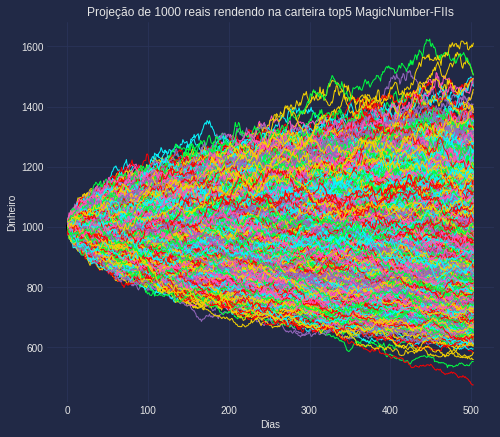

In [41]:
## premissas montecarlo

numero_simulacoes = 10000
dias_projetados = 252*2 #252 dias uteis -> proximos dois anos
capital_inicial = 1000 #o que vai ocorrer com 1000 reais?

#gerando retorno medio em forma de matriz

retorno_medio = retornos.mean(axis = 0).to_numpy()
matriz_retorno_medio = retorno_medio*np.ones(shape = (dias_projetados,numero_acoes))

#Nossa matriz L

L = LA.cholesky(matriz_covariancia)

#Gerando simulações

retornos_carteira = np.zeros([dias_projetados, numero_simulacoes])
montante_final = np.zeros(numero_simulacoes)

for s in range(numero_simulacoes):
    
    Rpdf = np.random.normal(size = (dias_projetados, numero_acoes))
    retornos_sinteticos = matriz_retorno_medio + np.inner(Rpdf, L) #Unico parametro aleatorio é Rpdf
    
    retornos_carteira[:,s] = np.cumprod(np.inner(pesos_carteira, retornos_sinteticos) + 1) * capital_inicial
    montante_final[s] = retornos_carteira[-1,s]
    
## Visualizando o retorno em 10.000 'realidades diferentes'
plt.figure(figsize = [8,7])
plt.title("Projeção de 1000 reais rendendo na carteira top5 MagicNumber-FIIs")
plt.plot(retornos_carteira,linewidth = 1)
plt.ylabel('Dinheiro')
plt.xlabel('Dias')

#salvar a imagem
plt.savefig('proj.png', dpi = 300)

plt.show()


In [42]:
#Criando as estatísticas para a nossa análise de carteira

montante_99 = str(np.percentile(montante_final,1))
montante_95 = str(np.percentile(montante_final,5))
montante_mediano = str(np.percentile(montante_final, 50))
cenarios_com_lucro = str(round((len(montante_final[montante_final > 1000])/len(montante_final))*100,2))+"%"

print("Ao investir R$ 1000,00 na carteira " + str(lista_acoes), "o resultado esperado para os próximos 2 anos, seguindo o método Monte Carlo com 10.000 simulações: \n")
print("50% de chance do montante ser maior que R$"+str(montante_mediano))
print("95% de chance do montante ser maior que R$"+str(montante_95))
print("99% de chance do montante ser maior que R$"+str(montante_99))
print("Cenários com lucro: "+str(cenarios_com_lucro))

Ao investir R$ 1000,00 na carteira ['JSRE11.SA', 'XPLG11.SA', 'BTLG11.SA', 'XPML11.SA', 'VISC11.SA'] o resultado esperado para os próximos 2 anos, seguindo o método Monte Carlo com 10.000 simulações: 

50% de chance do montante ser maior que R$920.7303738423361
95% de chance do montante ser maior que R$736.9466486748383
99% de chance do montante ser maior que R$669.1968610085685
Cenários com lucro: 27.21%


In [43]:
### versão completa
# enviar gmail com anexo

fromaddr = "thiagolaidler@gmail.com"
remetentes = ['thiago18@ov.ufrj.br','danielafmlima@gmail.com']
toaddr = " , ".join(remetentes)

# instance of MIMEMultipart
msg = MIMEMultipart()

# storing the senders email address
msg['From'] = fromaddr

# storing the receivers email address
msg['To'] = toaddr

# storing the subject
msg['Subject'] = "Relatorio Automático FIIs."

# string to store the body of the mail
body = f''' 
    Prezado,
    
    Segue a análise dos melhores fundos imobiliários com respeito ao Magic Number (aqueles que necessitam menor investimento para pagarem as proprias cotas).
    
    As cotas escolhidas para a carteira foram {lista_acoes}. 
    Com essa carteira, a chance de ter lucro nos proximo 2 anos será de {cenarios_com_lucro}. 
    Com R$1.000,00 investidos, haverá 50% de chance do montante ser maior que {montante_mediano} e 95% de chance do montante ser maior que {montante_95}.
    
    O rendimento mensal do IFIX: {round(retorno_mensal_ifix[-1],2)}%.
    O rendimento anual do IFIX: {round(retorno_anual_ifix[-1],2)}%.
    
    O rendimento mensal do IBOVESPA: {round(retorno_mensal_ibov[-1],2)}%.
    O rendimento anual de IBOVESPA: {round(retorno_anual_ibov[-1],2)}%.
    
    Segue em anexo os gráficos que mostram as possíveis evoluções destes rendimentos seguindo o método Monte Carlo.
    
    Abraços!
    
    
    Thiago Laidler.
    Astrofísico e Cientista de Dados.
    '''

# attach the body with the msg instance
msg.attach(MIMEText(body, 'plain'))

# open the file to be sent
filename = "proj.png"
attachment = open("/home/laidler/Documentos/Thiago/Financas/proj.png", "rb")

filename2 = "IFIX.png"
attachment2 = open("/home/laidler/Documentos/Thiago/Financas/IFIX.png", "rb")

filename3 = "carteira_ifix.xlsx"
attachment3 = open("/home/laidler/Documentos/Thiago/Financas/carteira_ifix.xlsx", "rb")


# instance of MIMEBase and named as p
p = MIMEBase('application', 'octet-stream')

# To change the payload into encoded form
p.set_payload((attachment).read())

# encode into base64
encoders.encode_base64(p)

p.add_header('Content-Disposition', "attachment; filename= %s" % filename)

# attach the instance 'p' to instance 'msg'
msg.attach(p)


# instance of MIMEBase and named as p
p2 = MIMEBase('application', 'octet-stream')

# To change the payload into encoded form
p2.set_payload((attachment2).read())

# encode into base64
encoders.encode_base64(p2)

p2.add_header('Content-Disposition', "attachment2; filename= %s" % filename2)

# attach the instance 'p' to instance 'msg'
msg.attach(p2)

# instance of MIMEBase and named as p
p3 = MIMEBase('application', 'octet-stream')

# To change the payload into encoded form
p3.set_payload((attachment3).read())

# encode into base64
encoders.encode_base64(p3)

p3.add_header('Content-Disposition', "attachment3; filename= %s" % filename3)

# attach the instance 'p' to instance 'msg'
msg.attach(p3)

####Para mais anexos, basta repetir para p3, p4... e assim em diante

# creates SMTP session
s = smtplib.SMTP('smtp.gmail.com', 587)

# start TLS for security
s.starttls()

# Authentication
s.login(fromaddr, "jtrhltixiyusiuzu")

# Converts the Multipart msg into a string
text = msg.as_string()

# sending the mail
s.sendmail(fromaddr, remetentes, text)

# terminating the session
s.quit()

(221,
 b'2.0.0 closing connection k4-20020a9d7604000000b006a1793e3571sm2044803otl.61 - gsmtp')

### Desafio:
#### Verificar se o filtro que utilizei para FIIs é um modelo promissor
 - 5: Webscrapping do site statusinvest
 - 6: refazer o modelo de investimento em factor investing
 - 7: Simular uma carteira de investimento que siga as compras previstas em julho de 2022 (rendimento mensal)
 - 8: Comparar com o IFIX na mesma época.
 
 (apenas como desafio, pois não consegui total acesso ao histórico da composição do IFIX nessa época exata)